# Imports

In [1]:
import sys
sys.path.append("../Face_detection")
sys.path.append("../")

import glob
import random
import zipfile
import os
import cv2

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from PIL import Image
from face_detection import predict_detected_faces
from data_augmenation_pipeline import DataAugmentationPipeline
from sklearn.metrics import f1_score
from tensorflow.keras.applications import MobileNetV2, MobileNet, EfficientNetB0, ResNet50, InceptionV3, VGG16
from tensorflow.keras import regularizers, initializers, Sequential
from tensorflow.keras.layers import Conv2D, Dropout, MaxPooling2D, SpatialDropout2D, GlobalMaxPooling2D, AveragePooling2D, Flatten, Dense, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2025-07-12 09:25:38.763649: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-12 09:25:38.806955: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-07-12 09:25:38.807027: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-07-12 09:25:38.807962: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-12 09:25:38.815942: I tensorflow/core/platform/cpu_feature_guar

In [2]:
gpus = tf.config.list_physical_devices('GPU')
print(gpus)

tf.config.set_visible_devices(gpus[0], 'GPU')  # Select GPU:1

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


# Hyperparameter for the model

In [3]:
batch_size = 24
target_size = (224, 224)
input_shape=(224, 224, 3)
learning_rate = 0.0001
num_classes = 4
kernel_s = (3, 3)
early_stopping = EarlyStopping(monitor='val_loss', restore_best_weights=True, patience=5)
class_names = ["Black_Hair", "Blond_Hair", "Brown_Hair", "Gray_Hair"]

# Data Augmentation

In [4]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=1.6793507278539355,
    shear_range=0.03712341367722668,
    zoom_range=0.07821799665503495,
    width_shift_range=0.07964116393707443,
    height_shift_range=0.06699636239891332,
    horizontal_flip=True,
    brightness_range=[0.7, 1.3]
)

train_gen=train_datagen.flow_from_directory(
    'Train',
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

valid_datagen = ImageDataGenerator(rescale=1./255)

valid_gen=valid_datagen.flow_from_directory(
    'Validate',
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

test_gen=valid_datagen.flow_from_directory(
    'Test',
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

Found 6400 images belonging to 4 classes.
Found 800 images belonging to 4 classes.
Found 800 images belonging to 4 classes.


# Plotting a batch of training data

Class labels: ['Black_Hair', 'Blond_Hair', 'Brown_Hair', 'Gray_Hair']


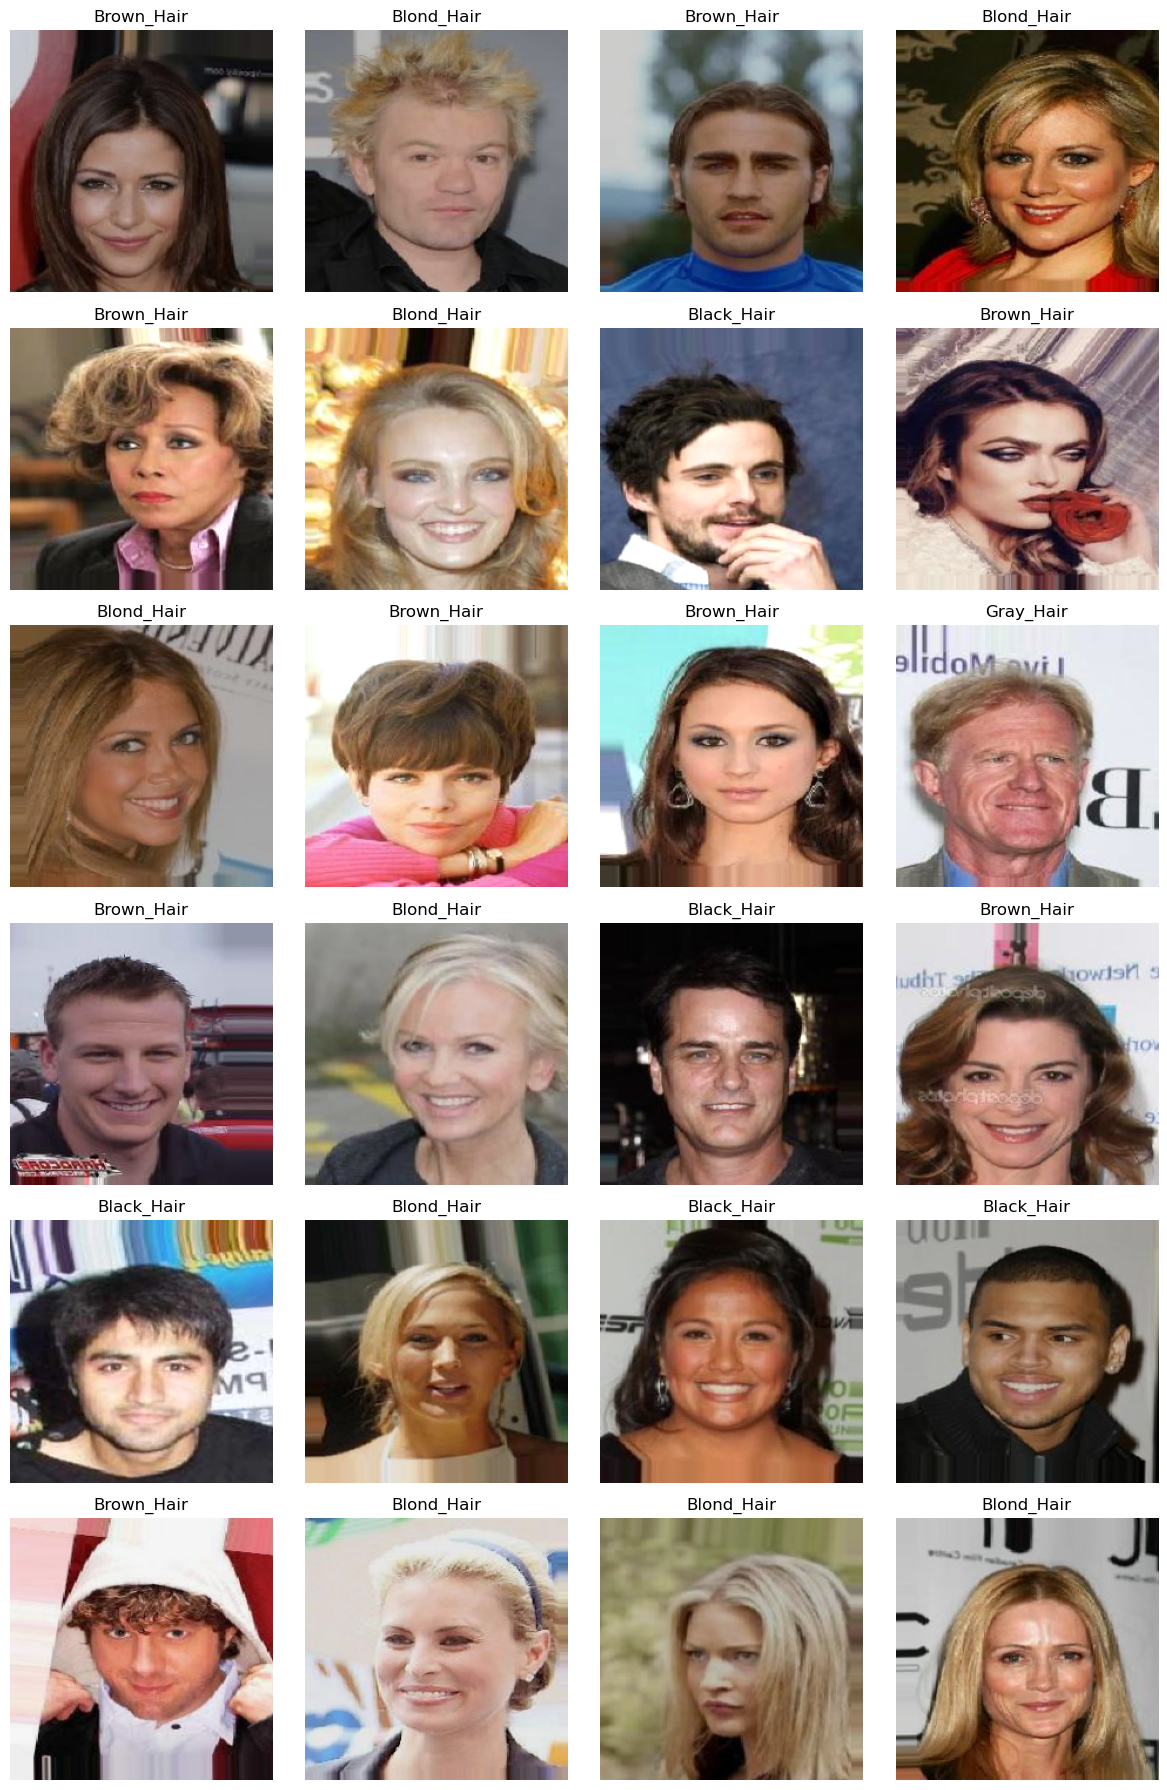

In [5]:
x_batch, y_batch = next(train_gen)
num_images = x_batch.shape[0]
cols = 4
rows = (num_images + cols - 1) // cols

class_labels = list(train_gen.class_indices.keys())
print(f"Class labels: {class_labels}")

fig, axes = plt.subplots(rows, cols, figsize=(12, 3 * rows))
axes = axes.flatten()

for i in range(num_images):
    ax = axes[i]
    ax.imshow(x_batch[i])
    
    class_index = y_batch[i].argmax()
    label = class_labels[class_index]
    
    ax.set_title(label)
    ax.axis('off')

for i in range(num_images, len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

# Set up and configure a model for training

In [8]:
# These two models are also not bad
# base_model = MobileNet(weights="imagenet", include_top=False, input_shape=(224, 224, 3)) # Is correct on the test data, but not on my own
# base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(224, 224, 3)) # Works for my images, but isn't correct on the test data

# https://arxiv.org/abs/1409.4842 - Paper of the Inception architecture
base_model = InceptionV3(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
# base_model.trainable = False 

base_model.trainable = True
for layer in base_model.layers[:-50]:
    layer.trainable = False

model = Sequential([
    base_model,
    Flatten(),
    Dense(1024, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 flatten_10 (Flatten)        (None, 51200)             0         
                                                                 
 dense_20 (Dense)            (None, 1024)              52429824  
                                                                 
 dropout_10 (Dropout)        (None, 1024)              0         
                                                                 
 dense_21 (Dense)            (None, 4)                 4100      
                                                                 
Total params: 74236708 (283.19 MB)
Trainable params: 59607236 (227.38 MB)
Non-trainable params: 14629472 (55.81 MB)
_________________________________________________________________


# Compile the model and start the training

In [9]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['acc'])

history = model.fit(
    train_gen,
    batch_size=batch_size,
    epochs=40,
    validation_data=valid_gen,
    steps_per_epoch=100,
    callbacks=[early_stopping]
)

Epoch 1/40
100/100 [==============================] - 34s 261ms/step - loss: 4.1622 - acc: 0.6171 - val_loss: 0.5063 - val_acc: 0.8125
Epoch 2/40
100/100 [==============================] - 25s 251ms/step - loss: 0.5561 - acc: 0.7893 - val_loss: 0.4644 - val_acc: 0.8313
Epoch 3/40
100/100 [==============================] - 25s 252ms/step - loss: 0.4882 - acc: 0.8233 - val_loss: 0.4195 - val_acc: 0.8462
Epoch 4/40
100/100 [==============================] - 25s 248ms/step - loss: 0.4630 - acc: 0.8279 - val_loss: 0.5035 - val_acc: 0.8325
Epoch 5/40
100/100 [==============================] - 25s 250ms/step - loss: 0.4088 - acc: 0.8445 - val_loss: 0.4533 - val_acc: 0.8487
Epoch 6/40
100/100 [==============================] - 25s 251ms/step - loss: 0.3909 - acc: 0.8612 - val_loss: 0.3911 - val_acc: 0.8687
Epoch 7/40
100/100 [==============================] - 25s 247ms/step - loss: 0.4024 - acc: 0.8524 - val_loss: 0.5185 - val_acc: 0.8462
Epoch 8/40
100/100 [==============================] - 2

# Data Augmenation Pipeline

In [4]:
def generate_random_config():
    return {
        'rotation': random.uniform(0, 10),             
        'zoom': random.uniform(0, 0.25),             
        'width_shift': random.uniform(0, 0.1),
        'height_shift': random.uniform(0, 0.1),
        'shear': random.uniform(0, 0.1),           
        'hflip': True,                                
        'brightness': random.choice([[0.7, 1.3], [0.8, 1.2], None]) 
}

results = []

for i in range(10):
    config = generate_random_config()
    print(f"\n[INFO] Running config {i+1}: {config}")
    pipeline = DataAugmentationPipeline(config=config, batch_size=batch_size, target_size=target_size, class_mode='categorical')
    
    train_gen = pipeline.get_train_generator()
    valid_gen = pipeline.get_valid_generator()
    test_gen = pipeline.get_test_generator()
    
    # Build the model for each iteration new
    base_model = InceptionV3(weights="imagenet", include_top=False, input_shape=input_shape)
    
    base_model.trainable = True
    for layer in base_model.layers[:-50]:
        layer.trainable = False

    model = Sequential([
        base_model,
        Flatten(),
        Dense(1024, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['acc']
    )
    
    history = model.fit(
        train_gen,
        batch_size=batch_size,
        epochs=20,
        validation_data=valid_gen,
        steps_per_epoch=100,
        callbacks=[early_stopping]
    )
    
    # Evaluate on test dataset
    test_loss, test_acc = model.evaluate(test_gen, verbose=0)
    
    results.append({
        'config': config,
        'val_acc': max(history.history['val_acc']),
        'test_acc': test_acc,
        'history': history.history
    })

# Sorted after best test accuracy
results = sorted(results, key=lambda x: x['test_acc'], reverse=True)

for r in results:
    print(f"\nConfig: {r['config']}\n-> Val Acc: {r['val_acc']:.4f} | Test Acc: {r['test_acc']:.4f}")




[INFO] Running config 1: {'rotation': 8.586473040549423, 'zoom': 0.08934310870196838, 'width_shift': 0.03679884454412221, 'height_shift': 0.025492261329539037, 'shear': 0.091478525940431, 'hflip': True, 'brightness': [0.8, 1.2]}
Found 6400 images belonging to 4 classes.
Found 800 images belonging to 4 classes.
Found 800 images belonging to 4 classes.


2025-07-09 17:04:01.243577: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46733 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:17:00.0, compute capability: 8.6


Epoch 1/20


2025-07-09 17:04:10.388181: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
2025-07-09 17:04:13.490411: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f04d4d51530 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-07-09 17:04:13.490470: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2025-07-09 17:04:13.503566: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1752080653.652252   67960 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


100/100 [==============================] - 41s 292ms/step - loss: 3.5091 - acc: 0.6363 - val_loss: 0.5083 - val_acc: 0.8125
Epoch 2/20
100/100 [==============================] - 25s 252ms/step - loss: 0.5246 - acc: 0.8025 - val_loss: 0.3590 - val_acc: 0.8575
Epoch 3/20
100/100 [==============================] - 26s 256ms/step - loss: 0.4516 - acc: 0.8350 - val_loss: 0.3779 - val_acc: 0.8525
Epoch 4/20
100/100 [==============================] - 25s 253ms/step - loss: 0.4255 - acc: 0.8446 - val_loss: 0.3580 - val_acc: 0.8575
Epoch 5/20
100/100 [==============================] - 25s 252ms/step - loss: 0.3896 - acc: 0.8608 - val_loss: 0.3852 - val_acc: 0.8438
Epoch 6/20
100/100 [==============================] - 27s 271ms/step - loss: 0.3880 - acc: 0.8566 - val_loss: 0.4030 - val_acc: 0.8600
Epoch 7/20
100/100 [==============================] - 25s 250ms/step - loss: 0.3535 - acc: 0.8771 - val_loss: 0.3988 - val_acc: 0.8637
Epoch 8/20
100/100 [==============================] - 25s 250ms/st

# Plot the results of the training with a Data Augmentation Pipeline

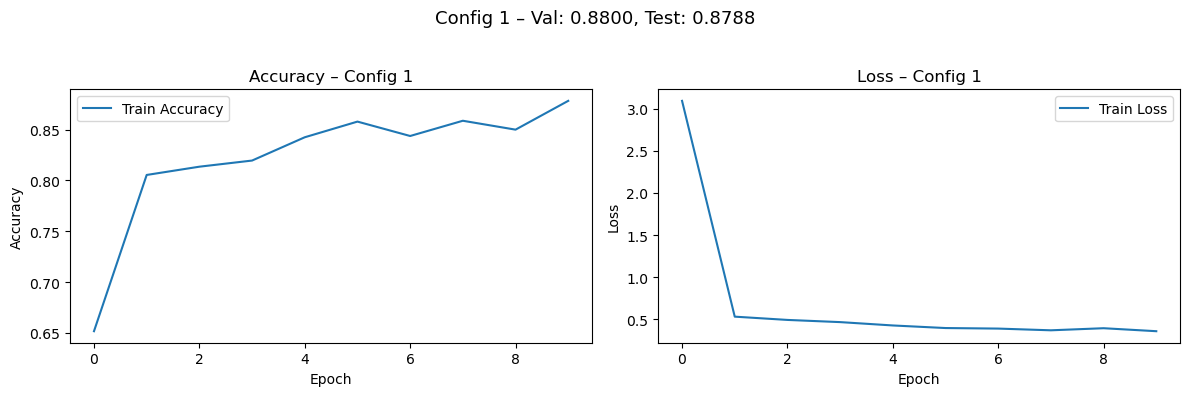

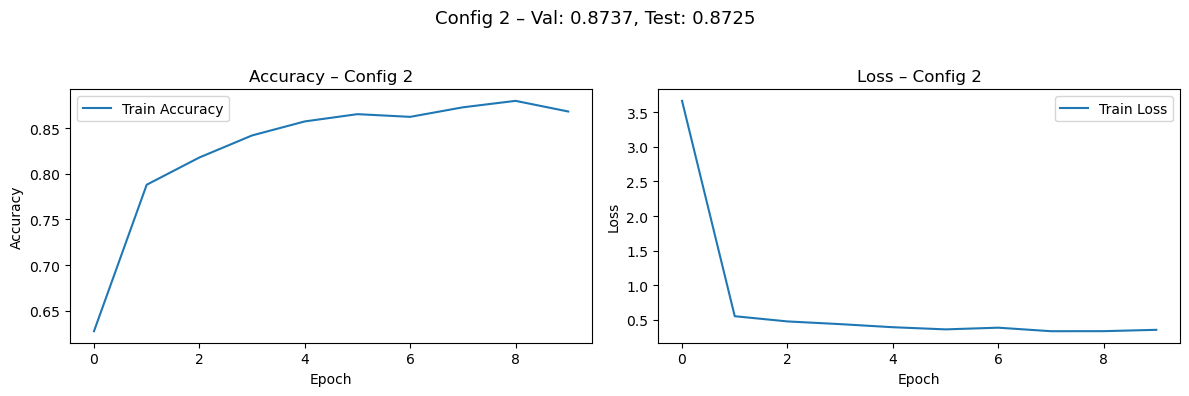

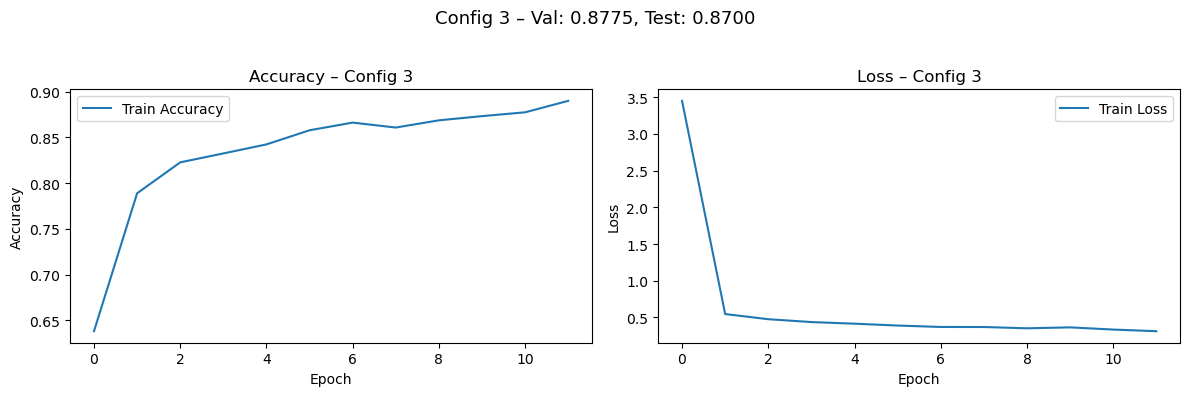

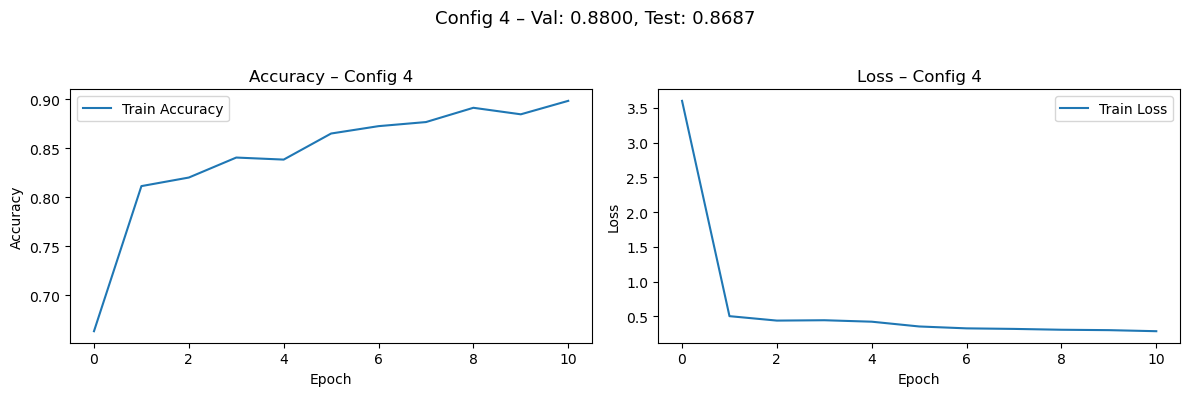

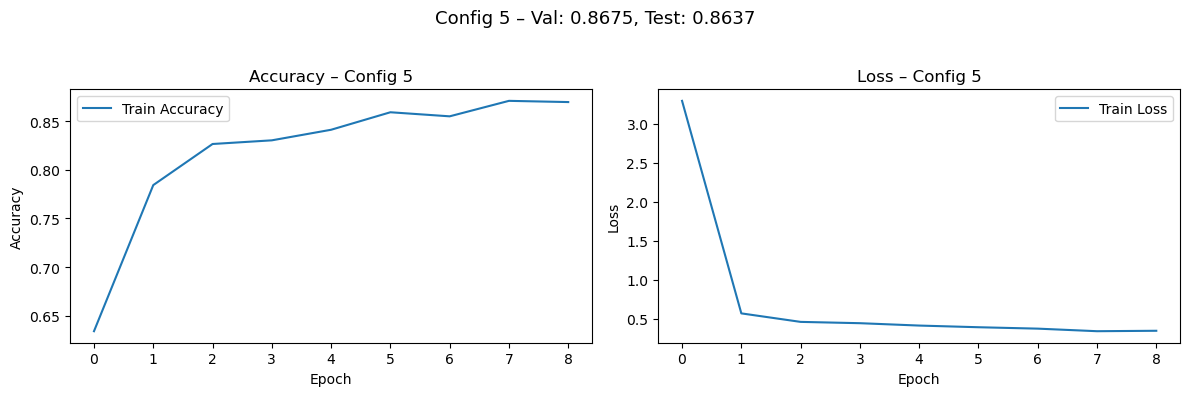

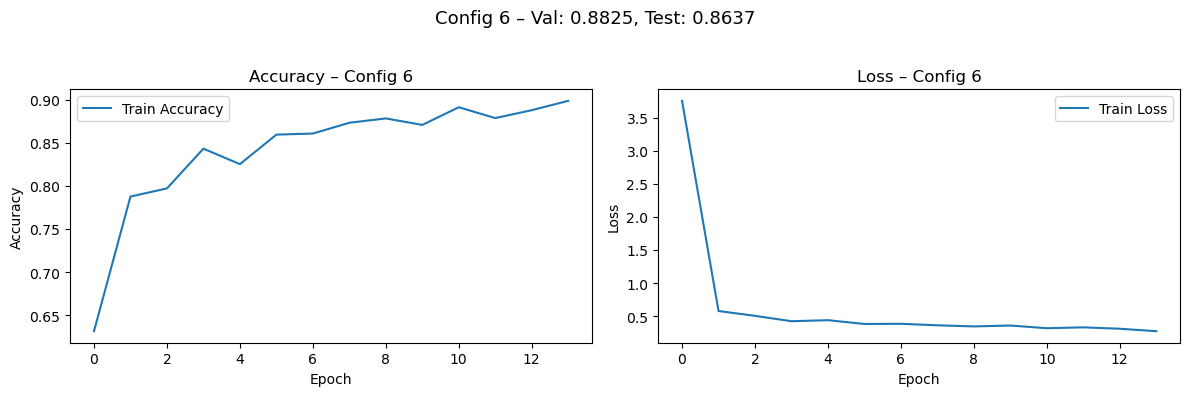

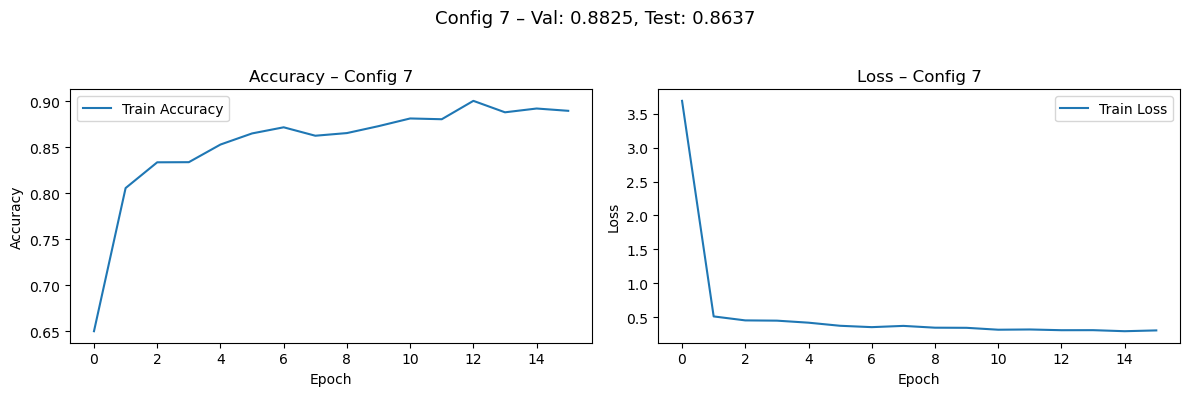

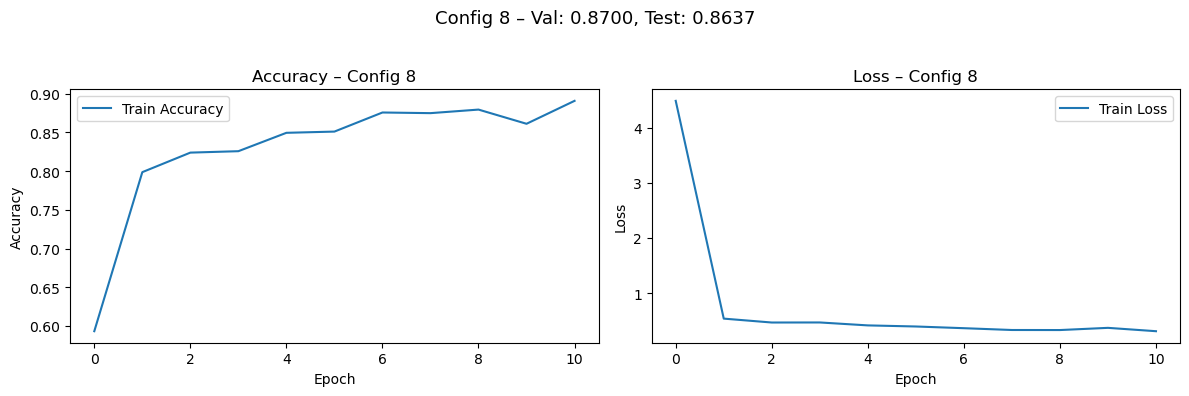

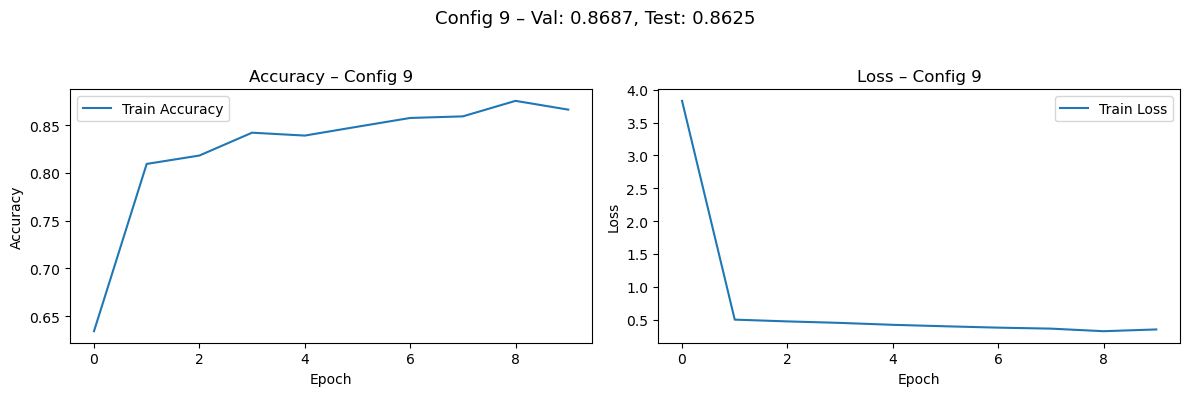

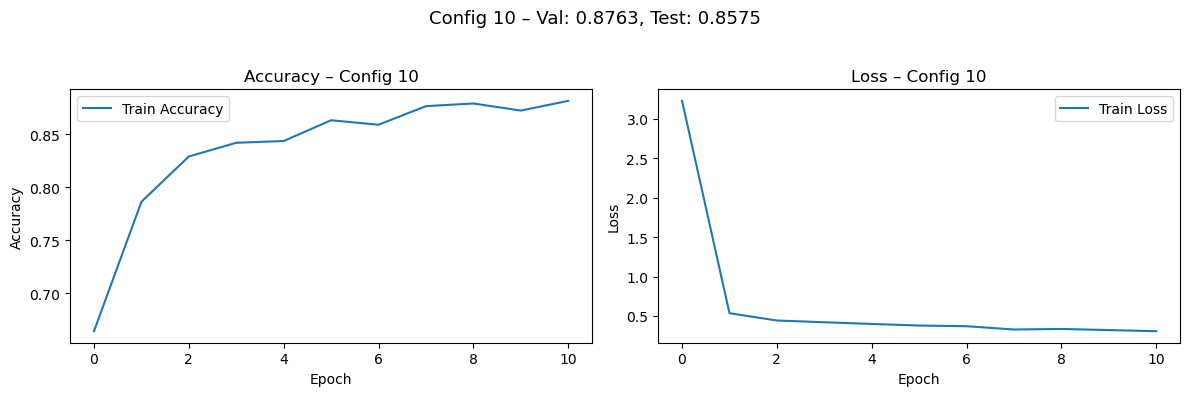

In [5]:
for i, r in enumerate(results):
    history = r.get('history', None)
    
    if history is None:
        print(f"[WARNING] No training history for config {i+1} available – please log the history.")
        continue

    config = r['config']
    val_acc = r['val_acc']
    test_acc = r['test_acc']

    acc_key = 'accuracy' if 'accuracy' in history else 'acc'
    val_acc_key = 'val_accuracy' if 'val_accuracy' in history else 'val_acc'

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history[acc_key], label='Train Accuracy')
    plt.title(f'Accuracy – Config {i+1}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history['loss'], label='Train Loss')
    plt.title(f'Loss – Config {i+1}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.suptitle(f'Config {i+1} – Val: {val_acc:.4f}, Test: {test_acc:.4f}', fontsize=13)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Plot the results of the training without a Data Augmentation Pipeline

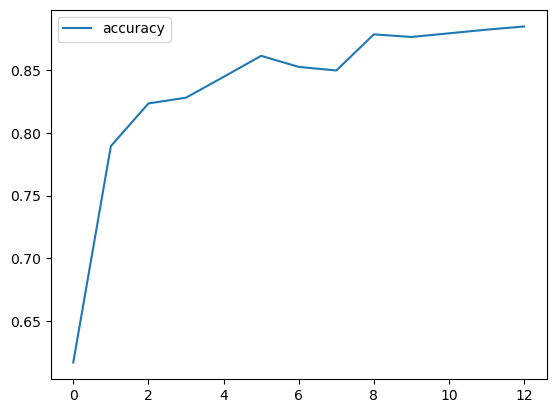

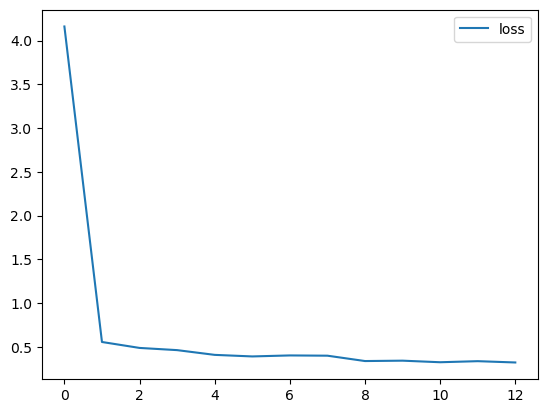

In [10]:
plt.plot(history.history['acc'], label='accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='loss')
plt.legend()

# Test the model on the test data

1/1 [==============================] - 1s 1s/step


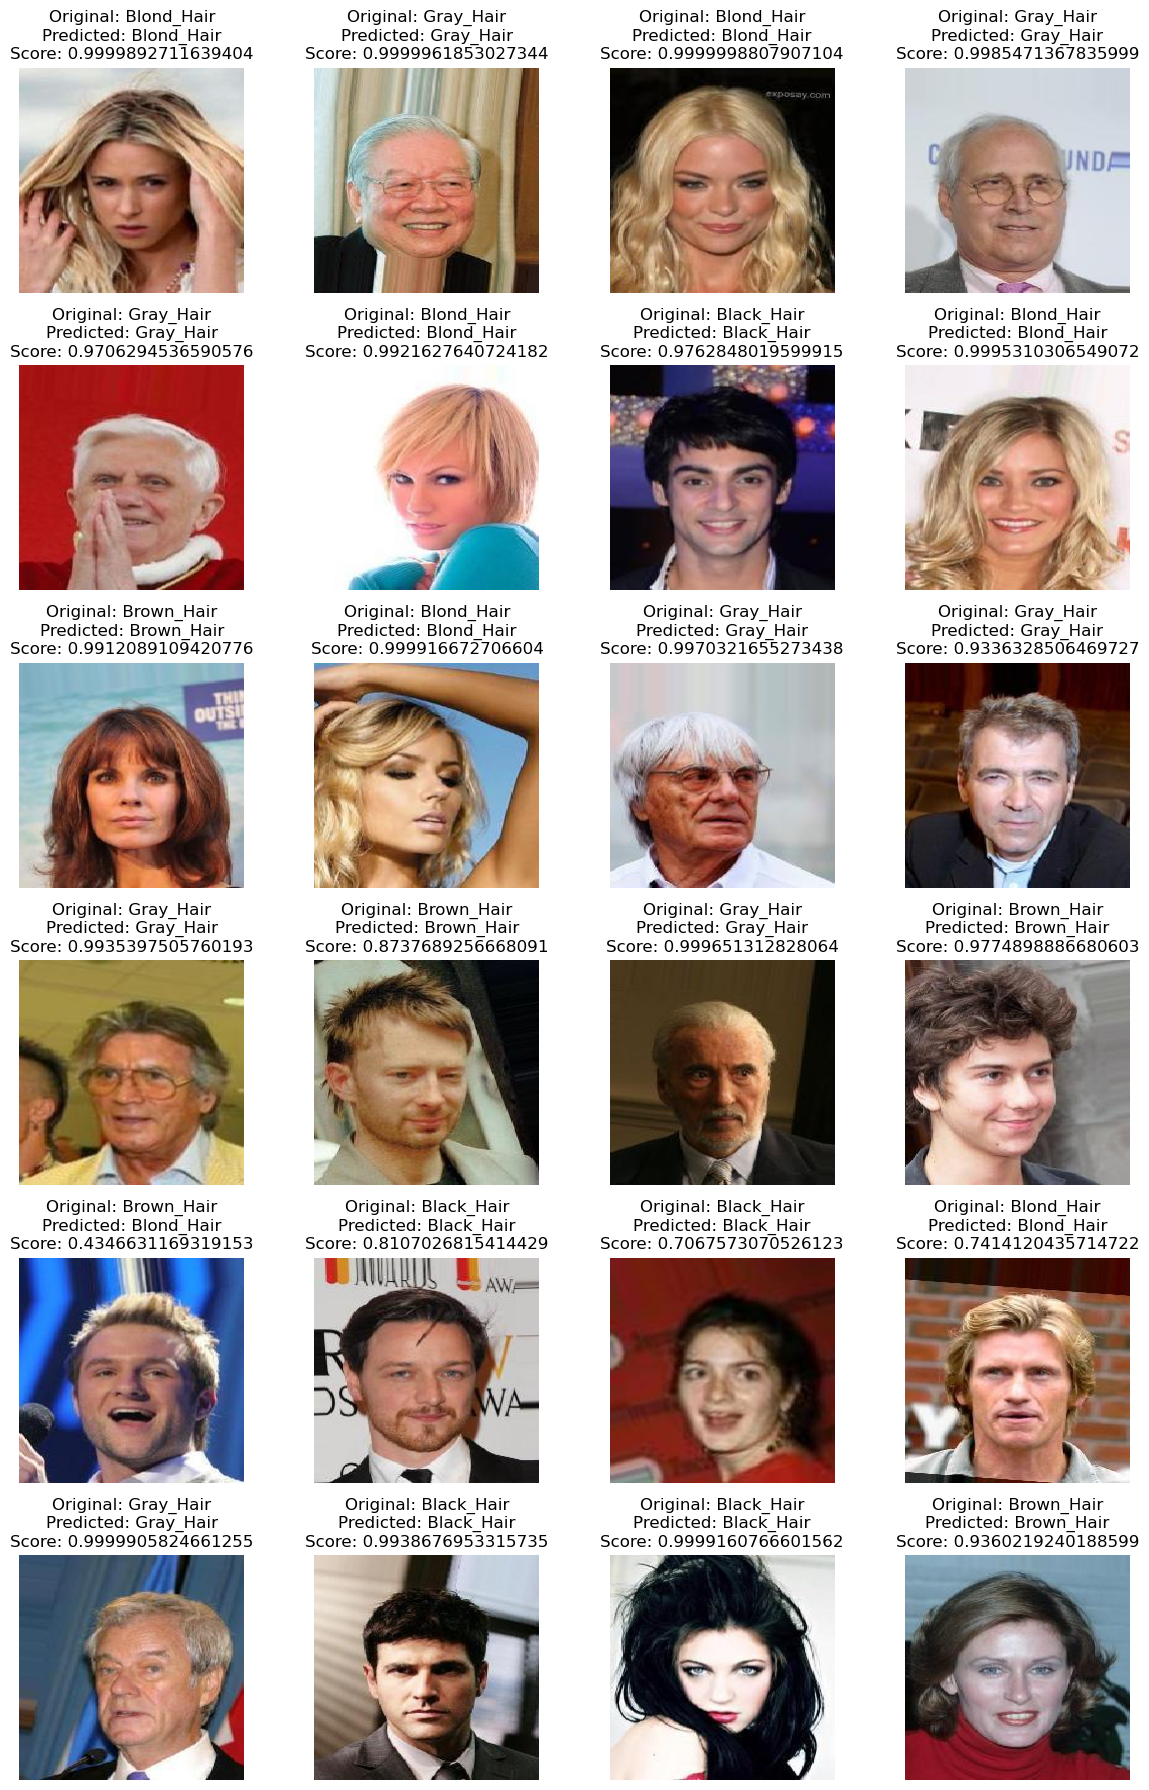

In [11]:
x_batch, y_batch = next(test_gen)
predictions = model.predict(x_batch)

predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(y_batch, axis=1)

class_names = ["Black_Hair", "Blond_Hair", "Brown_Hair", "Gray_Hair"]

num_images = x_batch.shape[0]
cols = 4
rows = (num_images + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(12, 3 * rows))
axes = axes.flatten()

for i in range(num_images):
    ax = axes[i]
    ax.imshow(x_batch[i])

    true_label = class_names[true_labels[i]]
    predicted_label = class_names[predicted_labels[i]]
    prediction_score = predictions[i][predicted_labels[i]]

    ax.set_title(f"Original: {true_label}\nPredicted: {predicted_label}\nScore: {prediction_score}")
    ax.axis('off')

for i in range(num_images, len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

# Test the model on my own data

1/1 [==============================] - 1s 1s/step


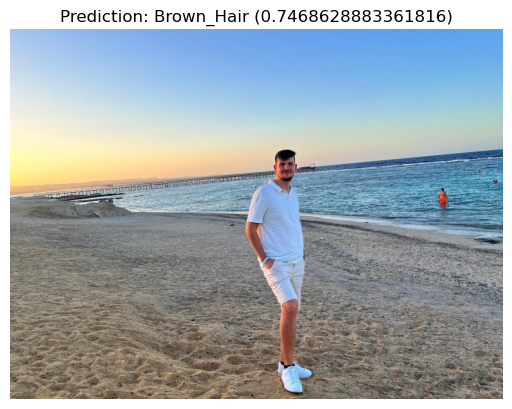

1/1 [==============================] - 0s 32ms/step


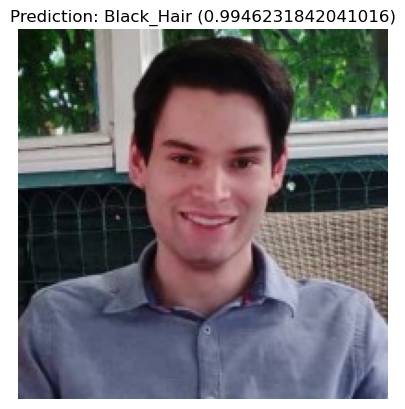

1/1 [==============================] - 0s 34ms/step


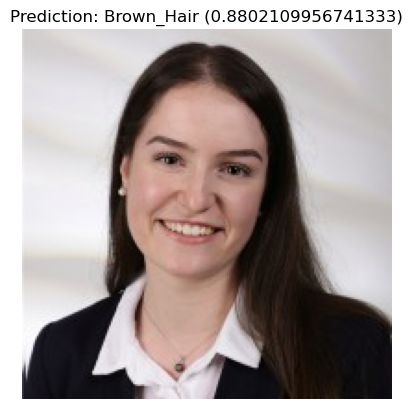

1/1 [==============================] - 0s 27ms/step


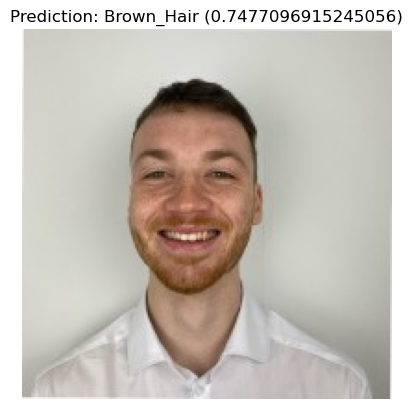

In [12]:
def edit_image(image_path: str) -> np.array: 
    img = load_img(image_path, target_size=target_size)

    img_array = img_to_array(img)
    img_array = img_array / 255.0 

    img_array = np.expand_dims(img_array, axis=0)

    return img_array


images = glob.glob('../Images/*.jpg')

for i, image in enumerate(images):
        img_array = edit_image(image)

        prediction = model.predict(img_array)

        predicted_label_index = np.argmax(prediction, axis=1)[0]
        predicted_label = class_names[predicted_label_index]
        confidence = prediction[0][predicted_label_index]

        plt.imshow(load_img(image))
        plt.title(f"Prediction: {predicted_label} ({confidence:})")
        plt.axis("off")
        plt.show()

# Evaluate the model ans save it to a file

In [13]:
model.evaluate(test_gen)
model.save("../Models/With_DA_Pipeline/Haircolor_classification")

34/34 [==============================] - 1s 38ms/step - loss: 0.3457 - acc: 0.8813
INFO:tensorflow:Assets written to: ../Models/With_DA_Pipeline/Haircolor_classification/assets


INFO:tensorflow:Assets written to: ../Models/With_DA_Pipeline/Haircolor_classification/assets


# Test the model on detected and extracted faces

In [4]:
print(f"Loading the model: Haircolor_classification")
model_with_pipeline = tf.keras.models.load_model("../Models/With_DA_Pipeline/Haircolor_classification")
model_without_pipeline = tf.keras.models.load_model("../Models/Without_DA_Pipeline/Haircolor_classification")

Loading the model: Haircolor_classification


2025-07-12 09:03:01.258578: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46733 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:17:00.0, compute capability: 8.6


Predicting with the model which was trained with the pipeline:
1/1 [==============================] - 0s 35ms/step


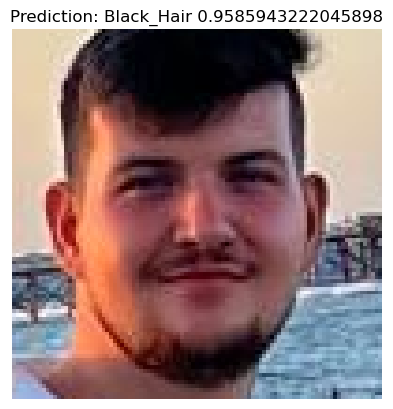

1/1 [==============================] - 0s 34ms/step


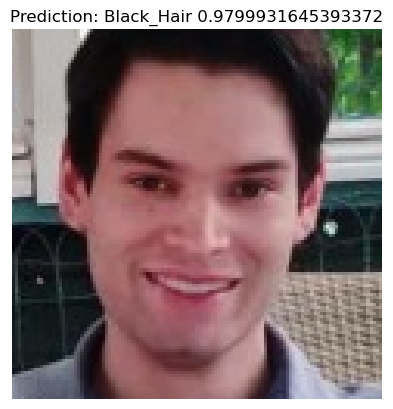

1/1 [==============================] - 0s 36ms/step


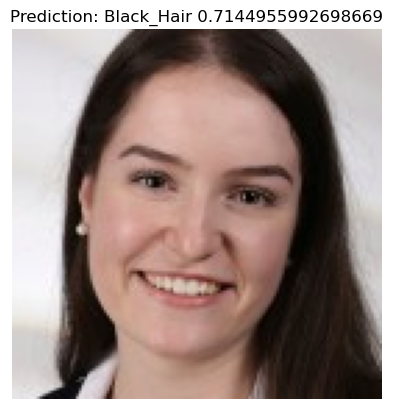

1/1 [==============================] - 0s 37ms/step


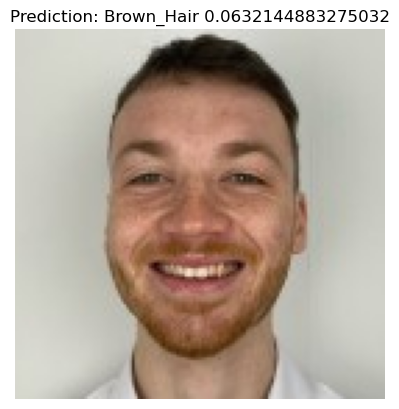

Predicting with the model which was trained without the pipeline:
1/1 [==============================] - 0s 39ms/step


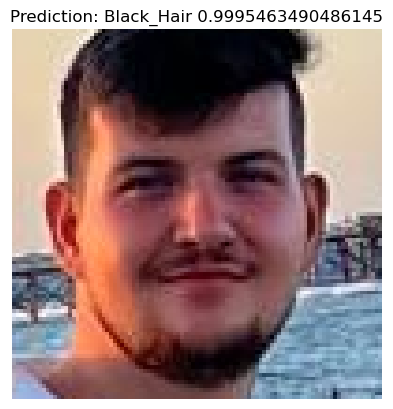

1/1 [==============================] - 0s 29ms/step


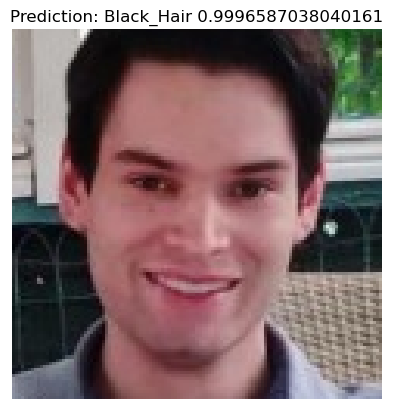

1/1 [==============================] - 0s 34ms/step


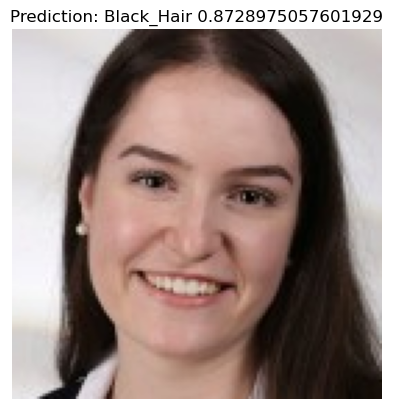

1/1 [==============================] - 0s 35ms/step


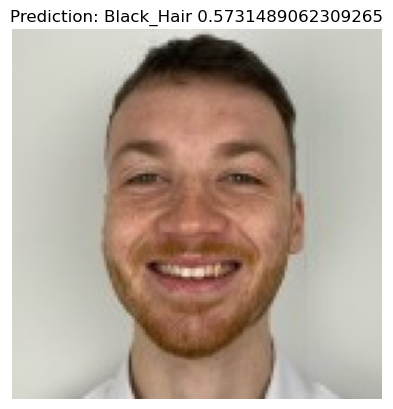

In [7]:
print("Predicting with the model which was trained with the pipeline:")
predict_detected_faces(model=model_with_pipeline, class_names=class_names, padding=0.2, categorical=True, image_directory="../Images/*.jpg")

print("Predicting with the model which was trained without the pipeline:")
predict_detected_faces(model=model_without_pipeline, class_names=class_names, padding=0.2, categorical=True, image_directory="../Images/*.jpg")